The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 学习率调度器
:label:`sec_scheduler`

到目前为止，我们主要关注如何更新权重向量的优化算法，而不是它们的更新速率。
然而，调整学习率通常与实际算法同样重要，有如下几方面需要考虑：

* 首先，学习率的大小很重要。如果它太大，优化就会发散；如果它太小，训练就会需要过长时间，或者我们最终只能得到次优的结果。我们之前看到问题的条件数很重要（有关详细信息，请参见 :numref:`sec_momentum`）。直观地说，这是最不敏感与最敏感方向的变化量的比率。
* 其次，衰减速率同样很重要。如果学习率持续过高，我们可能最终会在最小值附近弹跳，从而无法达到最优解。 :numref:`sec_minibatch_sgd`比较详细地讨论了这一点，在 :numref:`sec_sgd`中我们则分析了性能保证。简而言之，我们希望速率衰减，但要比$\mathcal{O}(t^{-\frac{1}{2}})$慢，这样能成为解决凸问题的不错选择。
* 另一个同样重要的方面是初始化。这既涉及参数最初的设置方式（详情请参阅 :numref:`sec_numerical_stability`），又关系到它们最初的演变方式。这被戏称为*预热*（warmup），即我们最初开始向着解决方案迈进的速度有多快。一开始的大步可能没有好处，特别是因为最初的参数集是随机的。最初的更新方向可能也是毫无意义的。
* 最后，还有许多优化变体可以执行周期性学习率调整。这超出了本章的范围，我们建议读者阅读 :cite:`Izmailov.Podoprikhin.Garipov.ea.2018`来了解个中细节。例如，如何通过对整个路径参数求平均值来获得更好的解。

鉴于管理学习率需要很多细节，因此大多数深度学习框架都有自动应对这个问题的工具。
在本章中，我们将梳理不同的调度策略对准确性的影响，并展示如何通过*学习率调度器*（learning rate scheduler）来有效管理。

## 一个简单的问题

我们从一个简单的问题开始，这个问题可以轻松计算，但足以说明要义。
为此，我们选择了一个稍微现代化的LeNet版本（激活函数使用`relu`而不是`sigmoid`，汇聚层使用最大汇聚层而不是平均汇聚层），并应用于Fashion-MNIST数据集。
此外，我们混合网络以提高性能。
由于大多数代码都是标准的，我们只介绍基础知识，而不做进一步的详细讨论。如果需要，请参阅 :numref:`chap_cnn`进行复习。


In [1]:
%matplotlib inline
import math
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from d2l import tensorflow as d2l


def net():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='relu',
                               padding='same'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=16, kernel_size=5,
                               activation='relu'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='relu'),
        tf.keras.layers.Dense(84, activation='sigmoid'),
        tf.keras.layers.Dense(10)])


batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 代码几乎与d2l.train_ch6定义在卷积神经网络一章LeNet一节中的相同
def train(net_fn, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu(), custom_callback = False):
    device_name = device._device_name
    strategy = tf.distribute.OneDeviceStrategy(device_name)
    with strategy.scope():
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        net = net_fn()
        net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    callback = d2l.TrainCallback(net, train_iter, test_iter, num_epochs,
                             device_name)
    if custom_callback is False:
        net.fit(train_iter, epochs=num_epochs, verbose=0,
                callbacks=[callback])
    else:
         net.fit(train_iter, epochs=num_epochs, verbose=0,
                 callbacks=[callback, custom_callback])
    return net

让我们来看看如果使用默认设置，调用此算法会发生什么。
例如设学习率为$0.3$并训练$30$次迭代。
留意在超过了某点、测试准确度方面的进展停滞时，训练准确度将如何继续提高。
两条曲线之间的间隙表示过拟合。


loss 0.205, train acc 0.924, test acc 0.897
54605.6 examples/sec on /GPU:0


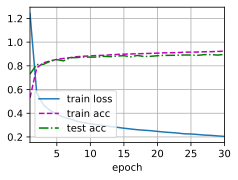

In [2]:
lr, num_epochs = 0.3, 30
train(net, train_iter, test_iter, num_epochs, lr)

## 学习率调度器

我们可以在每个迭代轮数（甚至在每个小批量）之后向下调整学习率。
例如，以动态的方式来响应优化的进展情况。


In [3]:
lr = 0.1
dummy_model = tf.keras.models.Sequential([tf.keras.layers.Dense(10)])
dummy_model.compile(tf.keras.optimizers.SGD(learning_rate=lr), loss='mse')
print(f'learning rate is now ,', dummy_model.optimizer.lr.numpy())

learning rate is now , 0.1


更通常而言，我们应该定义一个调度器。
当调用更新次数时，它将返回学习率的适当值。
让我们定义一个简单的方法，将学习率设置为$\eta = \eta_0 (t + 1)^{-\frac{1}{2}}$。


In [4]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

让我们在一系列值上绘制它的行为。


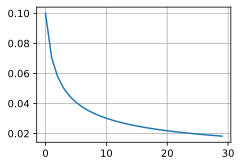

In [5]:
scheduler = SquareRootScheduler(lr=0.1)
d2l.plot(tf.range(num_epochs), [scheduler(t) for t in range(num_epochs)])

现在让我们来看看这对在Fashion-MNIST数据集上的训练有何影响。
我们只是提供调度器作为训练算法的额外参数。


loss 0.383, train acc 0.860, test acc 0.848
57799.7 examples/sec on /GPU:0


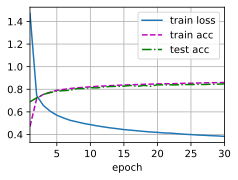

In [6]:
train(net, train_iter, test_iter, num_epochs, lr,
      custom_callback=LearningRateScheduler(scheduler))

这比以前好一些：曲线比以前更加平滑，并且过拟合更小了。
遗憾的是，关于为什么在理论上某些策略会导致较轻的过拟合，有一些观点认为，较小的步长将导致参数更接近零，因此更简单。
但是，这并不能完全解释这种现象，因为我们并没有真正地提前停止，而只是轻柔地降低了学习率。

## 策略

虽然我们不可能涵盖所有类型的学习率调度器，但我们会尝试在下面简要概述常用的策略：多项式衰减和分段常数表。
此外，余弦学习率调度在实践中的一些问题上运行效果很好。
在某些问题上，最好在使用较高的学习率之前预热优化器。

### 多因子调度器

多项式衰减的一种替代方案是乘法衰减，即$\eta_{t+1} \leftarrow \eta_t \cdot \alpha$其中$\alpha \in (0, 1)$。为了防止学习率衰减超出合理的下限，更新方程经常修改为$\eta_{t+1} \leftarrow \mathop{\mathrm{max}}(\eta_{\mathrm{min}}, \eta_t \cdot \alpha)$。


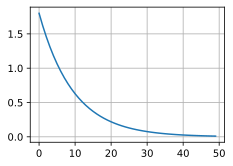

In [7]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
d2l.plot(tf.range(50), [scheduler(t) for t in range(50)])

接下来，我们将使用内置的调度器，但在这里仅解释它们的功能。

### 多因子调度器

训练深度网络的常见策略之一是保持分段稳定的学习率，并且每隔一段时间就一定程度学习率降低。
具体地说，给定一组降低学习率的时间，例如$s = \{5, 10, 20\}$每当$t \in s$时降低$\eta_{t+1} \leftarrow \eta_t \cdot \alpha$。
假设每步中的值减半，我们可以按如下方式实现这一点。


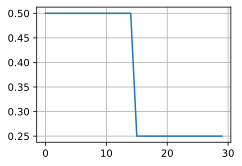

In [8]:
class MultiFactorScheduler:
    def __init__(self, step, factor, base_lr):
        self.step = step
        self.factor = factor
        self.base_lr = base_lr

    def __call__(self, epoch):
        if epoch in self.step:
            self.base_lr = self.base_lr * self.factor
            return self.base_lr
        else:
            return self.base_lr

scheduler = MultiFactorScheduler(step=[15, 30], factor=0.5, base_lr=0.5)
d2l.plot(tf.range(num_epochs), [scheduler(t) for t in range(num_epochs)])

这种分段恒定学习率调度背后的直觉是，让优化持续进行，直到权重向量的分布达到一个驻点。
此时，我们才将学习率降低，以获得更高质量的代理来达到一个良好的局部最小值。
下面的例子展示了如何使用这种方法产生更好的解决方案。


loss 0.239, train acc 0.911, test acc 0.885
57730.2 examples/sec on /GPU:0


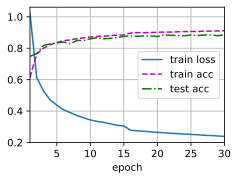

In [9]:
train(net, train_iter, test_iter, num_epochs, lr,
      custom_callback=LearningRateScheduler(scheduler))

### 余弦调度器

余弦调度器是 :cite:`Loshchilov.Hutter.2016`提出的一种启发式算法。
它所依据的观点是：我们可能不想在一开始就太大地降低学习率，而且可能希望最终能用非常小的学习率来“改进”解决方案。
这产生了一个类似于余弦的调度，函数形式如下所示，学习率的值在$t \in [0, T]$之间。

$$\eta_t = \eta_T + \frac{\eta_0 - \eta_T}{2} \left(1 + \cos(\pi t/T)\right)$$

这里$\eta_0$是初始学习率，$\eta_T$是当$T$时的目标学习率。
此外，对于$t > T$，我们只需将值固定到$\eta_T$而不再增加它。
在下面的示例中，我们设置了最大更新步数$T = 20$。


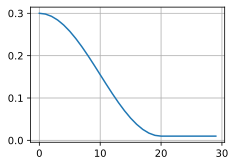

In [10]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
d2l.plot(tf.range(num_epochs), [scheduler(t) for t in range(num_epochs)])

在计算机视觉中，这个调度可以引出改进的结果。
但请注意，如下所示，这种改进并不能保证成立。


loss 0.259, train acc 0.905, test acc 0.886
57549.1 examples/sec on /GPU:0


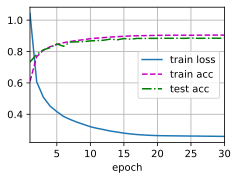

In [11]:
train(net, train_iter, test_iter, num_epochs, lr,
      custom_callback=LearningRateScheduler(scheduler))

### 预热

在某些情况下，初始化参数不足以得到良好的解。
这对于某些高级网络设计来说尤其棘手，可能导致不稳定的优化结果。
对此，一方面，我们可以选择一个足够小的学习率，
从而防止一开始发散，然而这样进展太缓慢。
另一方面，较高的学习率最初就会导致发散。

解决这种困境的一个相当简单的解决方法是使用预热期，在此期间学习率将增加至初始最大值，然后冷却直到优化过程结束。
为了简单起见，通常使用线性递增。
这引出了如下表所示的时间表。


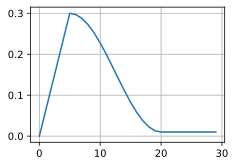

In [12]:
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(tf.range(num_epochs), [scheduler(t) for t in range(num_epochs)])

注意，观察前5个迭代轮数的性能，网络最初收敛得更好。


loss 0.283, train acc 0.896, test acc 0.876
57661.9 examples/sec on /GPU:0


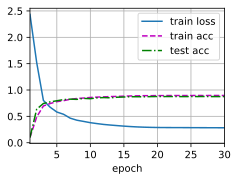

In [13]:
train(net, train_iter, test_iter, num_epochs, lr,
      custom_callback=LearningRateScheduler(scheduler))

预热可以应用于任何调度器，而不仅仅是余弦。
有关学习率调度的更多实验和更详细讨论，请参阅 :cite:`Gotmare.Keskar.Xiong.ea.2018`。
其中，这篇论文的点睛之笔的发现：预热阶段限制了非常深的网络中参数的发散量。
这在直觉上是有道理的：在网络中那些一开始花费最多时间取得进展的部分，随机初始化会产生巨大的发散。

## 小结

* 在训练期间逐步降低学习率可以提高准确性，并且减少模型的过拟合。
* 在实验中，每当进展趋于稳定时就降低学习率，这是很有效的。从本质上说，这可以确保我们有效地收敛到一个适当的解，也只有这样才能通过降低学习率来减小参数的固有方差。
* 余弦调度器在某些计算机视觉问题中很受欢迎。
* 优化之前的预热期可以防止发散。
* 优化在深度学习中有多种用途。对于同样的训练误差而言，选择不同的优化算法和学习率调度，除了最大限度地减少训练时间，可以导致测试集上不同的泛化和过拟合量。

## 练习

1. 试验给定固定学习率的优化行为。这种情况下你可以获得的最佳模型是什么？
1. 如果你改变学习率下降的指数，收敛性会如何改变？在实验中方便起见，使用`PolyScheduler`。
1. 将余弦调度器应用于大型计算机视觉问题，例如训练ImageNet数据集。与其他调度器相比，它如何影响性能？
1. 预热应该持续多长时间？
1. 你能把优化和采样联系起来吗？首先，在随机梯度朗之万动力学上使用 :cite:`Welling.Teh.2011`的结果。


[Discussions](https://discuss.d2l.ai/t/4335)
